# Big Data Final Project: Song Analysis
### Beske, Devico, Madden, & Stone

**The following code block contains necessary imports for the project...**

In [74]:
# Generic imports
import requests
import json
import urllib2
import csv
import re
import nltk
from matplotlib import pyplot as plt
from afinn import Afinn
import urllib
import musixmatch_config


# Custom imports
import spotify_api

In [16]:
BASEURL = 'http://lyric-api.herokuapp.com/api/find/'

with open('data/lyrics.csv', 'wb') as wf:
    w = csv.writer(wf, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    with open('data/regional-global-daily-latest.csv', 'rb') as f:
        r = csv.reader(f, delimiter=',')
        # Read title line
        next(r)
        # Loop through lines
        for row in r:
            try:
                data = json.load(urllib2.urlopen(BASEURL + urllib2.quote(row[2]) + '/' + urllib2.quote(row[1])))
                if data['err'] != 'not found':
                    w.writerow([row[2]] + [row[1]] + [data['lyric'].replace("\n"," ")])
            except:
                pass

In [18]:
# Parse lyrics
with open('data/lyrics.csv', 'rb') as rr:
    r = csv.reader(rr, delimiter='|')
    wordcount = {}
    for row in r:
        row = [l for l in row if l.strip()]
        row[-1] = re.sub('[^A-Za-z ]', '', row[-1]).lower()
        for w in row[-1].split():
            if(wordcount.get(w)):
                wordcount[w] += 1
            else:
                wordcount[w] = 1
    

In [25]:
# Parse wordcounts
nltk.download('stopwords')
new_wordcount = {}
rm_stopword_keys = [w for w in wordcount.keys() if w not in nltk.corpus.stopwords.words('english')]
for i in rm_stopword_keys:
    new_wordcount[i] = wordcount[i]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Value lists
v = []
# Key lists
k = []
for key, value in sorted(new_wordcount.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    if len(k) < 20:
        k.append(key)
        v.append(value)

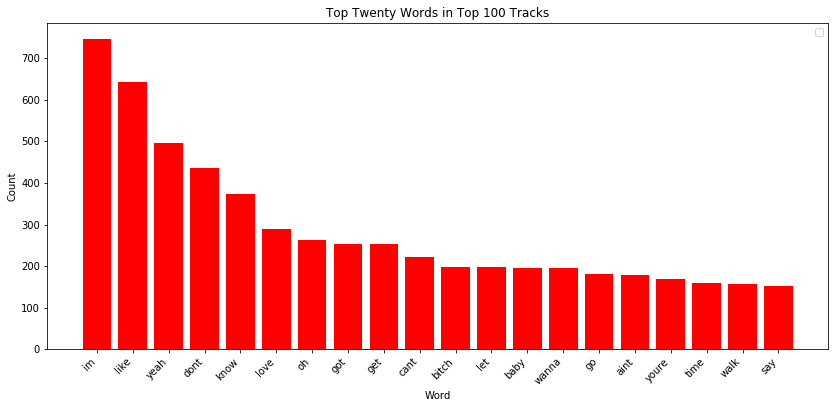

In [37]:
# Plot popular words
plt.figure(figsize=(14,6))
plt.title("Top Twenty Words in Top 100 Tracks")
plt.xlabel("Word")
plt.ylabel("Count")
plt.bar(k, v,width=0.8,color='r',align='center')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.show()

In [45]:
#Run sentiments on full songs
afinn = Afinn()
with open('data/lyrics.csv', 'rb') as rr:
    r = csv.reader(rr, delimiter='|')
    scores = {}
    for row in r:
        row = [l for l in row if l.strip()]
        row[-1] = re.sub('[^A-Za-z ]', '', row[-1]).lower()
        songscore = 0
        for w in row[-1].split():
            songscore += afinn.score(w)
        if len(row) < 3:
            scores[row[0]] = songscore
        else:
            scores[row[1]] = songscore
    

In [64]:
# Aggregate/sort sentiment scores on songs
# Value lists
sentiment_top_v = []
sentiment_bottom_v = []
# Key lists
sentiment_top_k = []
sentiment_bottom_k = []

for key, value in sorted(scores.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    if value >= 0:
        sentiment_top_k.append(key)
        sentiment_top_v.append(value)
    else:        
        sentiment_bottom_k.append(key)
        sentiment_bottom_v.append(value)
        
        
#Clean up song titles
sentiment_top_k = [i.strip() for i in sentiment_top_k]
sentiment_bottom_k = [i.strip() for i in sentiment_bottom_k]

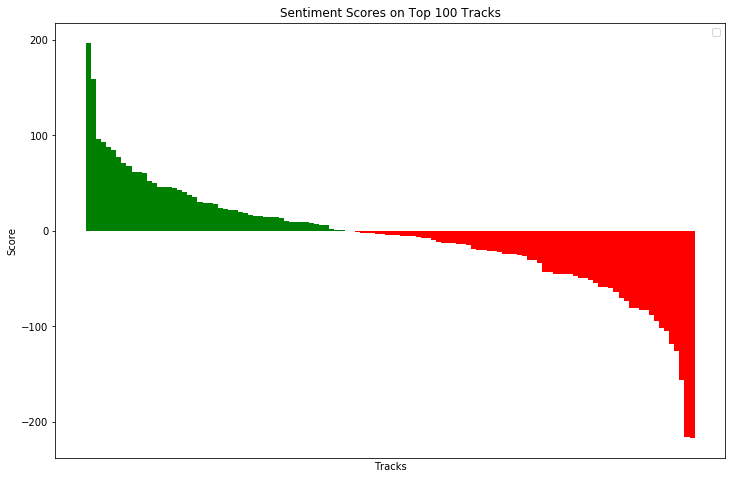

In [72]:
# Plot sentiments words
plt.figure(figsize=(12,8))
plt.title("Sentiment Scores on Top 100 Tracks")
plt.xlabel("Tracks")
plt.ylabel("Score")
plt.bar(sentiment_top_k, sentiment_top_v,width=1,color='g',align='center')
plt.bar(sentiment_bottom_k, sentiment_bottom_v,width=1,color='r',align='center')
plt.xticks([])
plt.legend(loc='upper right')
plt.show()

In [75]:
URL_BASE = "http://api.musixmatch.com/ws/1.1/"
MUSIXMATCH_API_TOKEN = musixmatch_config.apiKey

def musixmatch_api_generic(endpoint, **kwargs):
    kwargs['apikey'] = MUSIXMATCH_API_TOKEN
    querystring = ''.join([k + "=" + str(kwargs[k]) + "&" for k in kwargs.keys() if kwargs[k]])
    data = requests.get(URL_BASE + endpoint + '?' + querystring)
    return data.json()

In [92]:
# Get sentiment of each genre
with open('data/lyrics.csv', 'rb') as rr:
    r = csv.reader(rr, delimiter='|')
    genre_count = {}
    genre_score = {}
    for row in r:
        row = [l for l in row if l.strip()]
        try:
            mm_res = musixmatch_api_generic('track.search', q_track_artist=row[-2])['message']['body']['track_list'][0]
            genre = mm_res['track']['primary_genres']['music_genre_list'][0]['music_genre']['music_genre_name'].encode('utf-8')
            if genre_count.get(genre):
                genre_count[genre] += 1
            else:
                genre_count[genre] = 1

            row[-1] = re.sub('[^A-Za-z ]', '', row[-1]).lower()
            gscore = 0
            for w in row[-1].split():
                gscore += afinn.score(w)        

            if genre_score.get(genre):
                genre_score[genre] += gscore
            else:
                genre_score[genre] = gscore
        except:
            pass

In [94]:
# Aggregate/sort sentiment scores on genres
# Value lists
sentiment_g_top_v = []
sentiment_g_bottom_v = []
# Key lists
sentiment_g_top_k = []
sentiment_g_bottom_k = []

for k in genre_count:
    genre_score[k] /= genre_count[k]

for key, value in sorted(genre_score.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    if value >= 0:
        sentiment_g_top_k.append(key)
        sentiment_g_top_v.append(value)
    else:        
        sentiment_g_bottom_k.append(key)
        sentiment_g_bottom_v.append(value)
        

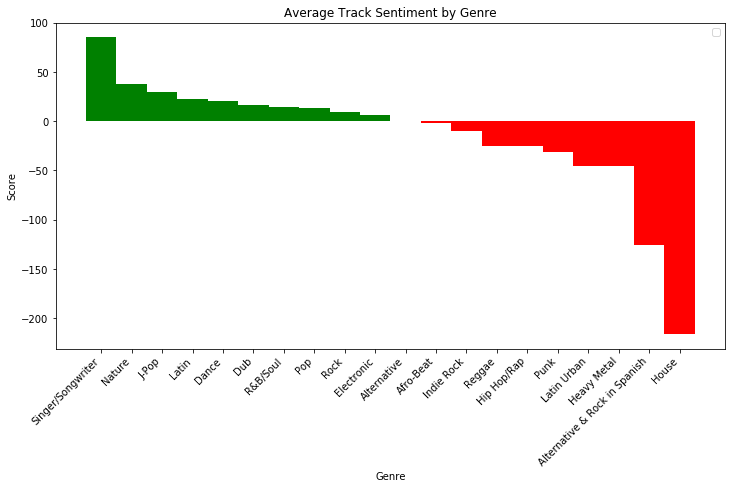

In [99]:
# Plot sentiment-average by genre
plt.figure(figsize=(12,6))
plt.title("Average Track Sentiment by Genre")
plt.xlabel("Genre")
plt.ylabel("Score")
plt.bar(sentiment_g_top_k, sentiment_g_top_v,width=1,color='g',align='center')
plt.bar(sentiment_g_bottom_k, sentiment_g_bottom_v,width=1,color='r',align='center')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.show()